<a href="https://colab.research.google.com/github/AITrading1995/AITrading1995/blob/main/Monte_calor_Distu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas-ta
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
!pip install numpy==1.23.5

In [4]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from tvDatafeed import TvDatafeed, Interval

In [5]:
def get_rate(symbol,exchange,bar):

  tv = TvDatafeed ()
  df = tv.get_hist(symbol=symbol,exchange=exchange,interval=Interval.in_15_minute,n_bars=bar)
  #df.index = pd.to_datetime(df.index, unit='s')
  #df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
  df.drop(columns='symbol', inplace=True)
  return df

In [6]:
symbol= 'XAUUSD'
exchange= 'OANDA'
bar=96*252

In [7]:
df=get_rate(symbol, exchange, bar)

In [8]:
df['returns'] = np.log(df.close/df.close.shift(1))

df.dropna(inplace=True)

In [9]:
S0 = df['close'].iloc[-2]
mu = np.mean(df.returns.dropna())
sigma =np.std(df.returns.dropna())
#sigma = ta.atr(df.high,df.low,df.close,14).iloc[-2]/S0
T = 1
N = 96
dt = T/N

In [10]:
Z = np.random.standard_normal(N)
W = np.cumsum(Z)*np.sqrt(dt)

In [11]:
t = np.linspace(0,T,N)

In [12]:
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

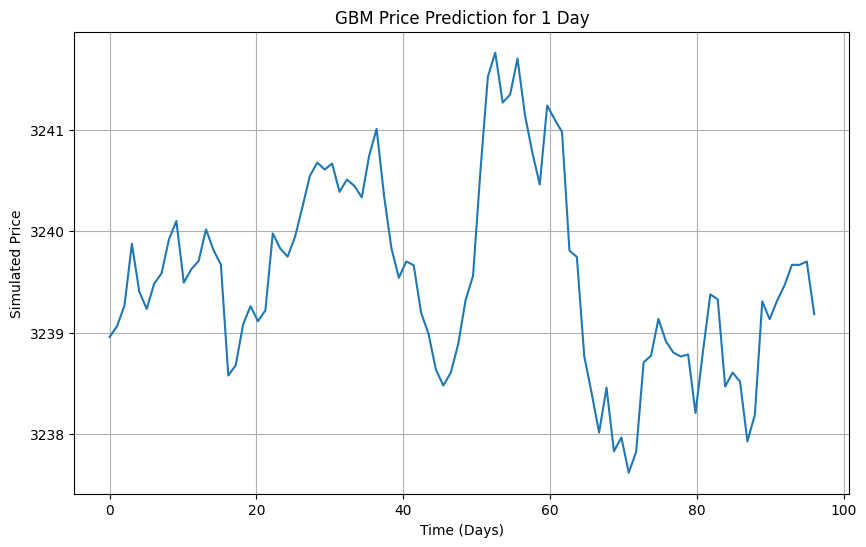

In [13]:
# แสดงกราฟราคา
plt.figure(figsize=(10, 6))
plt.plot(t * N, S)
plt.title('GBM Price Prediction for 1 Day')
plt.xlabel('Time (Days)')
plt.ylabel('Simulated Price')
plt.grid(True)
plt.show()

In [14]:
##Monte Carlo

M = 10_000_00
price_paths = np.zeros((M,N))
for i in range(M):
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    price_paths[i] = S0 * np.exp(X)

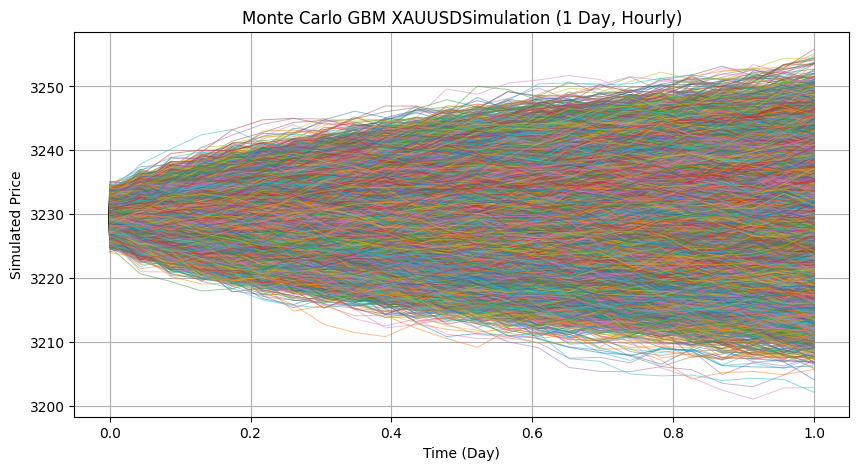

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(t, price_paths[i], lw=0.7, alpha=0.5)
plt.title(f"Monte Carlo GBM {symbol}Simulation (1 Day, Hourly)")
plt.xlabel("Time (Day)")
plt.ylabel("Simulated Price")
plt.grid(True)
plt.show()

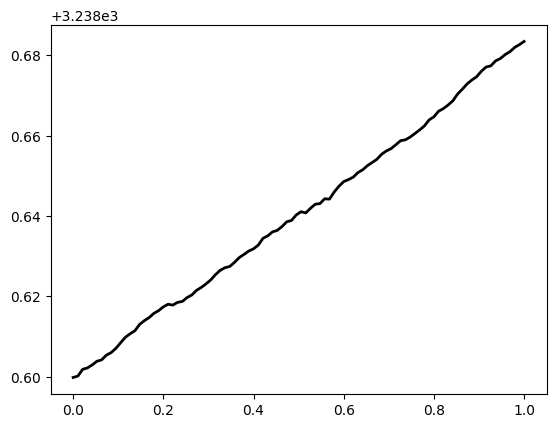

In [15]:
mean_path = price_paths.mean(axis=0)
plt.plot(t, mean_path, label='Mean Path', color='black', linewidth=2)

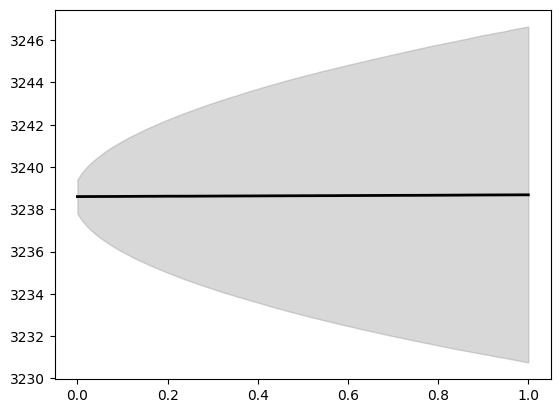

In [16]:
mean_path = price_paths.mean(axis=0)
plt.plot(t, mean_path, label='Mean Path', color='black', linewidth=2)
lower = np.percentile(price_paths, 2.5, axis=0)
upper = np.percentile(price_paths, 97.5, axis=0)

plt.fill_between(t, lower, upper, color='gray', alpha=0.3, label='95% Confidence Interval')

In [17]:
final_prices = price_paths[:, -1]
mean = np.mean(final_prices)
std = np.std(final_prices)

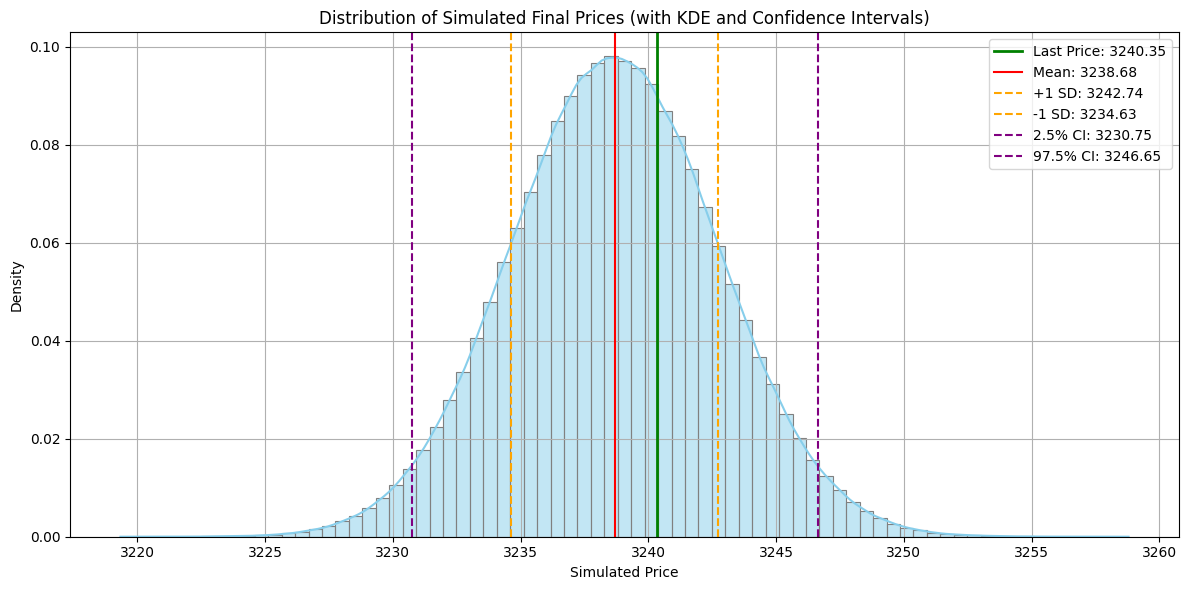

In [18]:
import seaborn as sns

# Final prices จาก simulation
final_prices = price_paths[:, -1]
mean = np.mean(final_prices)
std = np.std(final_prices)
lower_ci = np.percentile(final_prices, 2.5)
upper_ci = np.percentile(final_prices, 97.5)
last_price = df['close'].iloc[-1]

plt.figure(figsize=(12, 6))

# Histogram + KDE
sns.histplot(final_prices, bins=75, kde=True, color='skyblue', edgecolor='gray', stat="density")

# เส้นต่าง ๆ
plt.axvline(last_price, color='green', linestyle='-',lw=2, label=f'Last Price: {last_price:.2f}')
plt.axvline(mean, color='red', linestyle='-', label=f'Mean: {mean:.2f}')
plt.axvline(mean + std, color='orange', linestyle='--', label=f'+1 SD: {mean + std:.2f}')
plt.axvline(mean - std, color='orange', linestyle='--', label=f'-1 SD: {mean - std:.2f}')
plt.axvline(lower_ci, color='purple', linestyle='--', label=f'2.5% CI: {lower_ci:.2f}')
plt.axvline(upper_ci, color='purple', linestyle='--', label=f'97.5% CI: {upper_ci:.2f}')

# ตกแต่ง
plt.title('Distribution of Simulated Final Prices (with KDE and Confidence Intervals)')
plt.xlabel('Simulated Price')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()